In [176]:
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
import re
import pandas as pd
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
import pandas as pd
import pickle
# pd.set_options("display.max_colwidth","None")

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


In [177]:
import calendar
cal=list(calendar.month_name)
for i in list(calendar.month_name[1:]):
    cal.append(i[:3])

In [178]:
# # Plotting tools
# import pyLDAvis
# import pyLDAvis.gensim_models as gensimvis  

import warnings
# warnings.filterwarnings("ignore",category=DeprecationWarning)

 ##Topic Modelling: 
Topic modeling is an unsupervised learning technique used to extract topics from a large corpus of text automatically. Topics can be defined as the co-occurring terms that are frequently repeating in the text corpus. Topic modeling is helpful in various tasks such as clustering documents, understanding and summarizing an extensive collection of textual documents and retrieving information from an extensive collection of data, etc. In this notebook I will perform topic modelling using LDA(Latent Dirichlet Allocation) and BERT. 

Here I am using medium article dataset to perfom Topic Modelling. The dataset consist 350 articles related to AI, Machine Learning and Data Science.

## Exploring the dataset :

In [179]:
df_all_comments = pd.read_csv("generated_all_value_count_comments_nov.csv")
df_all_comments.drop(columns="Unnamed: 0",axis=1,inplace=True)
df_all_comments.head()

,V_COMMENTS,Counts
0,Mismatch ID number_NRIC,4180
1,SCC2: Match ID and/or Full Legal Name,3069
2,Mismatch Full Legal Name – Name Does Not Sound...,2985
3,Mismatch Full Legal Name_Name Does Not Sound S...,2227
4,Mismatch Full Legal Name_Name does not sound s...,1833


## Exploration of text Data

Removing special characters

1.re.sub("\n","",x)-line change character to be discarded
2.re.sub("Name – Name","Name",x)
3.re.sub("Name_Name","Name",x)
4. _ with ""
5 - with ""

omitting technical values of anchors
1. omitting date of birth
2. omitting most common names
3. omitting id values
4. omitting false-hit| true-hit 
3.Unknown|false hit|False Hit.|False Hit|True Hit|True Hit.|Rationale|Source -omit them
omitting Mohd,NORAINI,ABDULLAH,BINTI,system, legal , stated , ABD
4 Numbers



Removing useless comments

1.drop - Match ID and/or Full Legal Name (doubtfull)
2.Agreed with analyst recommendation|Agreed with analyst's recommendation|Agreed as per Maker comment|Agreed as per Maker's comment|AGREED WITH MAKER RECOMMENDATION|Agreed With Maker Comments - replace with substring

4.CSCDD7|CSCDD4 - Remove comments 
5CSCDD1 - remove ( still doubtful )
6 SCC6|No further review is required by analyst - remove comment
7 SC Status : No further review is required by analyst - remove comment
8 SC/DEL -remove

15 URL removal like - https://edmsfilenet.maybank.com.my/WorkplaceBFE/WcmSignIn.jsp?targetBase=https%3A%2F%2Fedmsfilenet.maybank.com.my%2FWorkplaceBFE&originPort=&originIp=172.31.75.67&targetUrl=WcmDefault.jsp
special characters - Mismatch Full Legal Name â€“ Name Does Not Sound Similar ,
16 Not removing any special character for now - Mismatch Full Legal Name_Name does not sound similar - watchperson Zhang Ping 张平 vs customer Zhang Peng 张鹏



In [180]:
# patt6=re.compile("https?://\S+|www\.\S+",re.IGNORECASE)
# # df_all_comments[df_all_comments["V_COMMENTS"].apply(lambda x: len(re.findall(patt6,x))>0)]
# ind=df_all_comments[df_all_comments["V_COMMENTS"].str.extract(r"(https?://\S+|www\.\S+)")[0].apply(lambda x: pd.notna(x))].index
# df_all_comments.loc[ind,"V_COMMENTS"].str.extract(r"(https?://.*\.com|www\..*\.com)").value_counts().to_csv("URL_in_comments.csv")
# # 

# Pre-processing on Data

### Step -1 removing noisy data

In [181]:
patt1=re.compile("Match ID and/or Full Legal Name",re.IGNORECASE)
# patt2=re.compile("Agreed with analyst recommendation|Agreed with analyst's recommendation|Agreed as per Maker comment|Agreed as per Maker's comment")
patt2=re.compile("(Agreed|agree) (to|with|as per) (analyst(('s)*)|maker(('s)*)) (comment|recommendation|is recommendation)",re.IGNORECASE)
patt3=re.compile("Unknown|false hit\.*|true hit\.*|Rationale|Source",re.IGNORECASE)
patt4=re.compile("CSCDD7|CSCDD1|CSCDD4",re.IGNORECASE)
patt5=re.compile("SCC6|No further review is required by analyst|SC/DEL",re.IGNORECASE)
patt6=re.compile("https?://\S+|www\.\S+",re.IGNORECASE)
patt7=re.compile("(%s)"%"|".join(cal)[1:],re.IGNORECASE)
patt8=re.compile("\s*(Mohd|NORAINI|ABDULLAH|BINTI|system|legal|stated|ABD|mahdzir|bin|khalid|siti|hajar|mohd|sallehudin|mohd|saddam|inie|binti|abdullah|noraini|norliza|binti|othman)\s*",re.IGNORECASE)
  

In [182]:
df_all_comments["V_COMMENTS_2"]=df_all_comments["V_COMMENTS"].apply(lambda x: re.sub("\n"," ",x)) #1

df_all_comments["V_COMMENTS_2"]=df_all_comments["V_COMMENTS_2"].apply(lambda x: re.sub("Name – Name","Name",x))    #2                                
df_all_comments["V_COMMENTS_2"]=df_all_comments["V_COMMENTS_2"].apply(lambda x: re.sub("Name_Name","Name",x))      #3                              
df_all_comments["V_COMMENTS_2"]=df_all_comments["V_COMMENTS_2"].apply(lambda x: re.sub("\s*_\s*|\s*-\s*|\s*,\s*"," ",x)) #4,5


df_all_comments=df_all_comments[df_all_comments["V_COMMENTS_2"].str.contains(patt1)==False] #7
df_all_comments["V_COMMENTS_2"]=df_all_comments["V_COMMENTS_2"].apply(lambda x: re.sub(patt2,"",x)) #8
df_all_comments["V_COMMENTS_2"]=df_all_comments["V_COMMENTS_2"].apply(lambda x: re.sub(patt3,"",x))  #  9
df_all_comments=df_all_comments[df_all_comments["V_COMMENTS_2"].str.contains(patt4)==False]        # 10
df_all_comments=df_all_comments[df_all_comments["V_COMMENTS_2"].str.contains(patt5)==False]       #11
df_all_comments["V_COMMENTS_2"]=df_all_comments["V_COMMENTS_2"].apply(lambda x: re.sub(patt6,"",x)) #15
df_all_comments["V_COMMENTS_2"]=df_all_comments["V_COMMENTS_2"].apply(lambda x: re.sub("[^\w\s\.]|\d","",x)) 
df_all_comments["V_COMMENTS_2"]=df_all_comments["V_COMMENTS_2"].apply(lambda x: re.sub("\d*","",x))    #date, year, accounts 6
df_all_comments["V_COMMENTS_2"]=df_all_comments["V_COMMENTS_2"].apply(lambda x: re.sub(patt7,"",x))    # month 6
df_all_comments["V_COMMENTS_2"]=df_all_comments["V_COMMENTS_2"].apply(lambda x: re.sub(patt8," ",x)) # 17


In [183]:
df_all_comments["V_COMMENTS_2"]=df_all_comments["V_COMMENTS_2"].str.lower()


In [184]:
df_all_comments_org=df_all_comments.copy()
# df_all_comments_org.to_csv("Stage_1_comments_after_pre_process_bigram_trigram.csv")

In [185]:
# Agreed with analyst recommendation|Agreed with analyst's recommendation|Agreed as per Maker comment|Agreed as per Maker's comment

In [186]:
# re.sub("Agreed with(a*) recommendation","","Agreed with recommendation")
# re.sub("Agreed (with|as per) recommendation","","Agreed recommendation")
patt=re.compile("Agreed (with|as per) (analyst(('s)*)|maker(('s)*)) (comment|recommendation)",re.IGNORECASE)
re.escape("analyst's")


"analyst's"

In [187]:
# df_all_comments=pd.read_csv("Stage_1_comments_after_pre_process_bigram_trigram.csv")

In [188]:
# x=re.compile("false hit\.*",re.IGNORECASE)
# re.findall(x,"false Hit.")
# txt="https://edmsfilenet.maybank.com.my/WorkplaceBFE/WcmSignIn.jsp?targetBase=https%3A%2F%2Fedmsfilenet.maybank.com.my%2FWorkplaceBFE&originPort=&originIp=172.31.75.67&targetUrl=WcmDefault.jsp"

# re.findall("https?://\S+|www\.\S+",txt)

In [189]:
# df_all_comments[df_all_comments["V_COMMENTS"].str.contains("Mismatch Full Legal Name_Name does not sound similar - watchperson")].head(1)["V_COMMENTS"]

In [190]:
df_all_comments["V_COMMENTS_2"]

0                                  mismatch id number nric
2                mismatch full name does not sound similar
3                mismatch full name does not sound similar
4                mismatch full name does not sound similar
5        mismatch yobage. comparison was made between c...
                               ...                        
13566    mismatch profile watch person reported age  re...
13567    mismatch id nric .watch list nric is . as per ...
13568    mismatch profile. customer who is software and...
13569    mismatch yobage watch person yob is  info from...
13570    mismatch profile. watchperson on   sentenced t...
Name: V_COMMENTS_2, Length: 13536, dtype: object

In [191]:
df_all_comments["V_COMMENTS_2"]=df_all_comments["V_COMMENTS_2"].apply(lambda x : "" if pd.isna(x) else x)

In [192]:
df_all_comments=df_all_comments[df_all_comments["V_COMMENTS_2"].apply(lambda x : len(x)!=0)]

In [193]:
#lowercase the articles 
df_all_comments.V_COMMENTS = df_all_comments.V_COMMENTS.apply(lambda t : t.lower())

Need to check whether to remove top x count words and last y count words

**Expanding contractions:** Contractions are the shortened form of the words like it's, hasn't. We expand them for better analysis of our V_COMMENTS data. I have taken these contractions from [Analytics Vidhay's article](http://https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-V_COMMENTS-data/).

In [194]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}



In [195]:
# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))
contractions_re


re.compile(r"(ain't|'s|aren't|can't|can't've|'cause|could've|couldn't|couldn't've|didn't|doesn't|don't|hadn't|hadn't've|hasn't|haven't|he'd|he'd've|he'll|he'll've|how'd|how'd'y|how'll|I'd|I'd've|I'll|I'll've|I'm|I've|isn't|it'd|it'd've|it'll|it'll've|let's|ma'am|mayn't|might've|mightn't|mightn't've|must've|mustn't|mustn't've|needn't|needn't've|o'clock|oughtn't|oughtn't've|shan't|sha'n't|shan't've|she'd|she'd've|she'll|she'll've|should've|shouldn't|shouldn't've|so've|that'd|that'd've|there'd|there'd've|they'd|they'd've|they'll|they'll've|they're|they've|to've|wasn't|we'd|we'd've|we'll|we'll've|we're|we've|weren't|what'll|what'll've|what're|what've|when've|where'd|where've|who'll|who'll've|who've|why've|will've|won't|won't've|would've|wouldn't|wouldn't've|y'all|y'all'd|y'all'd've|y'all're|y'all've|you'd|you'd've|you'll|you'll've|you're|you've)",
re.UNICODE)

### Step-2 expanding contractions

In [196]:
# Function for expanding contractions
def expand_contractions(V_COMMENTS,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, V_COMMENTS)

# Expanding Contractions in the V_COMMENTS data
df_all_comments.V_COMMENTS = df_all_comments.V_COMMENTS.apply(lambda x:expand_contractions(x))

### step -3 removing stopwords after tokenizing using word_tokenize

**Removing Stopwords and Puctuations**: Stopwords are the words that are highly occurred in a language; they do not add any significance to the sentence. "a," "an," "the," "in" are some examples of stopwords. So we generally ignore stop words during our NLP task. In some NLP tasks, stop words are also important, but stopwords are unnecessary for topic modeling. We also remove punctuation marks because they are also unnecessary and do not contribute anything.

In [197]:
# print(stopwords.words('english'))

In [198]:
stop_words = set(stopwords.words('english')) 

In [199]:
def remove_stopwords(document):
    "Return the articles after remvoing stopwords"
    article_tokens = word_tokenize(document) 
    filtered_article = [word for word in article_tokens if not word in stop_words] 
    return " ".join(filtered_article)

In [200]:
#removing stopwords
df_all_comments.V_COMMENTS_2=df_all_comments.V_COMMENTS_2.apply(lambda x: remove_stopwords(x))

### step-4 removing Punctuations

In [201]:
print(f"These are the punctuations which string.punctuation consist :  {string.punctuation}")

These are the punctuations which string.punctuation consist :  !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [202]:
# '[%s]' % re.escape(string.punctuation)

In [203]:
#removing Punctuations 
df_all_comments.V_COMMENTS_2=df_all_comments.V_COMMENTS_2.apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

In [204]:
# df_all_comments.V_COMMENTS_2

In [205]:
# #removing digits
# df_all_comments.V_COMMENTS_2 = df_all_comments.V_COMMENTS_2.apply(lambda x: re.sub('\d*','', x))

# df_all_comments.V_COMMENTS_2[50]

There are still some marks like quotation marks, hypen and apostrophe still remaining in the article, we also need to remove them.

In [206]:
# df_all_comments.V_COMMENTS_2 = df_all_comments.V_COMMENTS_2.apply(remove_extra_marks)

In [207]:
# def remove_extra_marks(article):
#     extra_keys = ["’","—","”","“"]
#     article_tokens = word_tokenize(article) 
#     filtered_article = [word for word in article_tokens if not word in extra_keys] 
#     return " ".join(filtered_article)
    
# df_all_comments.V_COMMENTS_2 = df_all_comments.V_COMMENTS_2.apply(remove_extra_marks)

In [208]:
#printing arbitrary example to visulise clean data
df_all_comments.V_COMMENTS_2[50]

''

## bi-grams /tri-grams

In [209]:
import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = df_all_comments.V_COMMENTS_2.values.tolist()
data_words = list(sent_to_words(data))
print(data_words)



# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100) 



IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [210]:
# bigram

In [211]:
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
# bigram_mod


In [212]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc])
    return texts_out

In [213]:
# Form Bigrams
# dfmake_bigrams(data_words_nostops)

texts=df_all_comments.V_COMMENTS_2.apply(lambda x: x.split()).to_list()

In [214]:
data_words_bigrams=make_bigrams(data_words)


In [215]:
data_words_trigrams=make_trigrams(data_words_bigrams)

In [216]:
# data_words_bigrams
# data_words_trigrams

In [217]:
import spacy

In [218]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_trigrams)

print(data_lemmatized[:1][0][:30])

['mismatch', 'i', 'd', 'number', 'nric']


In [219]:
# data_lemmatized

In [220]:
# z=pickle.load(open("dict.sav","rb"))
# class dict1:
#     def __init__(self):
#         self.id2word=id2word
# xt=dict1()
# id2word=z.id2word

In [175]:
import gensim.corpora as corpora
class dict1:
    def __init__(self):
        self.id2word=id2word


z=pickle.load(open("dict.sav","rb"))

# xt=dict1()
id2word=z.id2word

texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts] 

NameError: name 'data_lemmatized' is not defined

In [ ]:
print(corpus[:1][0][:30])

In [ ]:



# # Create Dictionary
# id2word = corpora.Dictionary(data_lemmatized)

# # Create Corpus
# texts = data_lemmatized

# # Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts] 

# View
print(corpus[:1][0][:30])

In [ ]:
df_all_comments["Tokens"]=data_lemmatized
df_all_comments["id_2_feature"]=corpus

In [ ]:

df_all_comments[df_all_comments["id_2_feature"].apply(lambda x: np.any(pd.isna(x)))]

In [ ]:
lda_model_best = pickle.load(open("lda_model_tfidf_lemmatizer_bi_tri200.30.3.sav","rb"))

In [ ]:
# lda_model = gensim.models.LdaMulticore(corpus=corpus,
#                                        id2word=id2word,
#                                        num_topics=10, 
#                                        random_state=100,
#                                        chunksize=100,
#                                        passes=10,
#                                        per_word_topics=True)

In [ ]:
# Print the Keyword in the 10 topics
pprint(lda_model_best.print_topics())
doc_lda = lda_model_best[corpus]

In [ ]:
len(id2word)

In [ ]:
# df_all_comments.loc[155,"id_2_feature"]
df_all_comments.loc[155,"Tokens"]

## Latent Dirichlet Allocation[LDA]:  

LDA algorithm is an unsupervised learning algorithm that works on a probabilistic statistical model to discover topics that the document contains automatically. <br> 
This algorithm works on certain assumptions. The assumption is that the document was generated by picking a set of topics and picking a set of words for each topic. In other words, we can say that the document is a probability distribution over the latent topics, and topics are probability distribution over the words.

Now let's understand the work methodology of LDA using Plate Diagram:
<br>

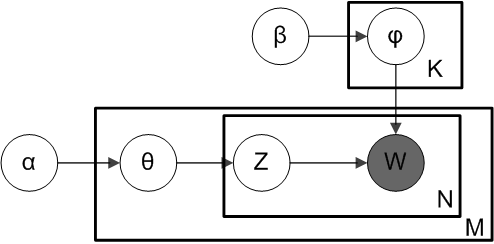
             
               **Plate Diagram of LDA model**

The above image is taken from [Wikipedia](http://https://upload.wikimedia.org/wikipedia/commons/thumb/4/4d/Smoothed_LDA.png/377px-Smoothed_LDA.png)

Here, $\alpha$ and $\beta$ are two hyperparameters that we have to initialise manually, and they symbolize per topic distribution($\alpha$) and per topic word distribution($\beta$), respectively. And **Z** is the topic for the **N**-th word in document **M**, and **W** is the specific word. We can only see W(specific words) in the documents because it is only an observable variable, and all others are latent.

$\theta$ is the matrix where rows are the documents; columns are topics, and $\theta(i,j)$ represents the probability of $ith$ document containing $jth$ topic. Similarly, $\phi$ is the matrix where rows are the topics; columns are words, and $\phi(i,j)$ represents the probability of $ith$ topic containing $jth$ word. According to the distribution of $\phi$; **K** individual words are generated for the topics.

With the help of this LDA, try to estimate the words that belong to each topic and find the topics in documents accordingly.

In [ ]:
import pickle
# pickle.dump(lda_model,open("lda_model_lemmatizer_bi_tri.sav","wb"))


In [ ]:
# lda_model = pickle.load(open("lda_model_lemmatizer_bi_tri.sav","rb"))

In [ ]:
# Get the top words for each topic
# top_words_per_topic = []
# for topic_id in range(lda_model_best.num_topics):
#     top_words = [id2word[word_id] for word_id, prob in lda_model_best.get_topic_terms(topic_id, topn=10)]
#     top_words_per_topic.append(top_words)


In [ ]:
# dict1={}
# for i,j in zip(range(len(top_words_per_topic)),top_words_per_topic):
#     dict1[i]=j

In [ ]:
df_all_comments.reset_index(inplace=True)

In [ ]:
df_all_comments.drop("index",axis=1,inplace=True)

In [ ]:
# get_document_topics(corpus)
# for i, doc in enumerate(corpus):
#     print("Document", i+1)
#     print(lda_model_best.get_document_topics(doc))

In [ ]:
# df_all_comments[]

In [ ]:
# Compute Perplexity
# print('\nPerplexity : ', lda_model_best.log_perplexity(corpus)) 

# # Compute Coherence Score
# coherence_model_lda = CoherenceModel(model=lda_model_best, texts=data_lemmatized,corpus=corpus, dictionary=id2word, coherence='c_v')
# coherence_lda = coherence_model_lda.get_coherence()
# print('\nCoherence Score: ', coherence_lda)

need to work on
1)increasing the number of topics  and no. of words in each cloud  -tuning part
2)identifying the root word - Lemmatyzing, stemming
usage of bi-grams & tri-grams
3)topic 3-pre-processing - reomval of names -Mohd,NORAINI,ABDULLAH,BINTI,
4)system, legal , stated , ABD

doubt - number ,within, SDN BHD , Pvt. Ltd. , Berhad

### Visualising Topics:

In [ ]:
# pip install pyLDAvis

In [ ]:
# pip install gensimvis

In [ ]:
# Visualize the topics
# pyLDAvis.enable_notebook()
# vis = gensimvis.prepare(lda_model, corpus, id2word)
# vis

To measure how good is our model we can use **perplexity score** and **coherence socre**. The lower score of perplexity is better for the model.

In [ ]:
df_all_comments

In [ ]:
# doc_lda = lda_model_best[corpus]
# x=lda_model_best.print_topics()
# y={}
# for i,j in x:
#     y[i]=j
    

In [ ]:
# df_all_comments["Topic"]=""
# df_all_comments["All_Topic_Probabilities"]=""
# df_all_comments["Topic No"]=""
# for i, doc in enumerate(corpus):
#       topic=sorted(lda_model_best.get_document_topics(doc),key=lambda x: x[1],reverse=True)[0][0]
#       df_all_comments["Topic No"].loc[i]=topic  
#       df_all_comments["Topic"].loc[i]=y[topic]
#       df_all_comments["All_Topic_Probabilities"].loc[i]=lda_model_best.get_document_topics(doc)
# #     .index(max(dict(lda_model_best.get_document_topics(doc)).values()))
# #      y[topic]

In [ ]:
# df_all_comments["Topic words"]=df_all_comments["Topic No"].apply(lambda x: dict1[x])

In [ ]:
# df_all_comments.to_csv("Output_of_topic_modelling.csv")
# len(corpus)
# df_all_comments.loc[221574:,["V_COMMENTS_2"]]

In [ ]:
# df_all_comments[df_all_comments["All_Topic_Probabilities"].apply(lambda x:type(x)==str )]["All_Topic_Probabilities"]
# model.get_document_topics(doc)

In [ ]:
# df_all_comments.to_csv("Output_of_topic_modelling_20_bow_bi_tri.csv")

In [ ]:
# import pickle
# pickle.dump(lda_model,open("lda_model_l_bi_tri.sav","wb"))

In [ ]:
# model = pickle.load(open("lda_model_lemmatizer_bi_gram.sav","rb"))
# import pickle
# model = pickle.load(open("lda_model.sav","rb"))

This notebook is mainly focused on LDA implementation for coherence score you can read this [medium article](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0).

### Using tf-idf for feature extraction


In [ ]:
import pandas as pd
import numpy as np 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
from gensim.models import TfidfModel

In [ ]:
import numpy as np
tfidf = TfidfModel(corpus, smartirs='ntc')


In [ ]:
print(tfidf[corpus][1])
tfidf_corpus=tfidf[corpus]
# corpus_example = [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:2]]

In [ ]:
df_all_comments["TFIDF_Feature"]=[doc for doc in tfidf_corpus]

In [ ]:
# df_all_comments

In [ ]:
# lda_tfidf_model = gensim.models.ldamodel.LdaModel(corpus=tfidf_corpus,
#                                            id2word=id2word,
#                                            num_topics=10, 
#                                            random_state=100,
#                                            update_every=1,
#                                            chunksize=100,
#                                            passes=10,
#                                            alpha='symmetric',
#                                            per_word_topics=True,
#                                            eta = 0.6)

In [ ]:
# lda_best_model

In [ ]:
# Print the Keyword in the 10 topics
pprint(lda_model_best.print_topics())
# doc_lda = lda_tfidf_model[corpus]

In [ ]:
# [lda_model_best[doc] for doc in tfidf_corpus ]

In [ ]:
# get_document_topics(corpus)
for i, doc in enumerate(tfidf_corpus):
    print("Document", i+1)
    print(lda_model_best.get_document_topics(doc))

In [ ]:
import pickle
# pickle.dump(lda_tfidf_model,open("lda_model_tfidf_lemmatizer_bi_tri.sav","wb"))


In [ ]:
# lda_tfidf_model1= pickle.load(open("lda_model_tfidf_lemmatizer_bi_tri.sav","rb"))

In [ ]:
# # Compute Perplexity
# print('\nPerplexity : ', lda_tfidf_model1.log_perplexity(corpus)) 

# # Compute Coherence Score
# coherence_model_lda_tf_idf = CoherenceModel(model=lda_tfidf_model1, texts=data_lemmatized,corpus=tfidf_corpus, dictionary=id2word, coherence='c_v')
# coherence_lda = coherence_model_lda_tf_idf.get_coherence()
# print('\nCoherence Score: ', coherence_lda)

In [ ]:
# Compute Perplexity
print('\nPerplexity : ', lda_model_best.log_perplexity(corpus)) 

# Compute Coherence Score
coherence_model_lda_tf_idf = CoherenceModel(model=lda_model_best, texts=data_lemmatized,corpus=tfidf_corpus, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda_tf_idf.get_coherence()
print('\nCoherence Score: ', coherence_lda)

In [ ]:
top_words_per_topic = []
for topic_id in range(lda_model_best.num_topics):
    top_words = [id2word[word_id] for word_id, prob in lda_model_best.get_topic_terms(topic_id, topn=10)]
    top_words_per_topic.append(top_words)

In [ ]:
dict2={}
for i,j in zip(range(len(top_words_per_topic)),top_words_per_topic):
    dict2[i]=j

This notebook is mainly focused on LDA implementation for coherence score you can read this [medium article](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0).

In [ ]:
# doc_lda = model[corpus]
x=lda_model_best.print_topics()
y={}
for i,j in x:
    y[i]=j
    

In [ ]:
df_all_comments["Topic_tfidf_lda"]=""
df_all_comments["All_Topic_tfidf_Probabilities"]=""
df_all_comments["TF_tfidf_Topic_No"]=""
for i, doc in enumerate(tfidf_corpus):
      topic=sorted(lda_model_best.get_document_topics(doc),key=lambda x: x[1],reverse=True)[0][0]
      df_all_comments["TF_tfidf_Topic_No"].loc[i]=topic  
      df_all_comments["Topic_tfidf_lda"].loc[i]=y[topic]
      df_all_comments["All_Topic_tfidf_Probabilities"].loc[i]=lda_model_best.get_document_topics(doc)
#     .index(max(dict(model.get_document_topics(doc)).values()))
#      y[topic]

In [ ]:
df_all_comments["TF IDF Topic words"]=df_all_comments["TF_tfidf_Topic_No"].apply(lambda x: dict2[x])

In [ ]:
df_all_comments["Topic_tfidf_lda"].value_counts()

In [ ]:
df_all_comments.to_csv("Output_of_topic_modelling_final_20_bi_tri_nov.csv")

## the end

In [ ]:
import ast
import pandas as pd
import numpy as np 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
# importing all necessary modules
from gensim.models import Word2Vec
import gensim
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import ast

In [ ]:
df_new=pd.read_csv("Output_of_topic_modelling_final_20_bi_tri_nov.csv")

In [ ]:
df_new.head()
df_new.drop("Unnamed: 0",axis=1,inplace=True)

In [ ]:
# df_new["Topic"].apply(lambda x:pd.isna(x))

In [ ]:
df_new["V_COMMENTS_2"]=df_new["V_COMMENTS_2"].apply(lambda x:"" if pd.isna(x) else x)
df_new=df_new[df_new["V_COMMENTS_2"].apply(lambda x: len(x)!=0)]

df_new["V_COMMENTS_2"].apply(lambda x: type(x)).unique()

# df_new["Topic"].apply(lambda x:pd.isna(x))
df_new["Tokens"]=df_new["Tokens"].apply(lambda x: ast.literal_eval(x))


df_new=df_new[df_new["Tokens"].apply(lambda x: len(x)!=0)]

In [ ]:
df_new["TF IDF Topic words"]=df_new["TF IDF Topic words"].apply(lambda x: ast.literal_eval(x))

In [ ]:

df_new["V_COMMENTS_2"]=df_new["V_COMMENTS_2"].apply(lambda x:"" if pd.isna(x) else x)
# df_new["Tokens"]=df_new["Tokens"].apply(lambda x: ast.literal_eval(x))

In [ ]:
df_new["TF IDF Topic words"]=df_new["TF IDF Topic words"].apply(lambda x:[i.split("_") for i in x])

In [ ]:
df_new["TF IDF Topic words"]

In [ ]:
l=[]
for i in df_new["TF IDF Topic words"]:
    l1=[]
    for word in i:
        for j in word:
            l1.append(j)
    l.append(l1)

In [ ]:
l

In [ ]:
df_new["TF IDF Topic words"]=l

In [ ]:
l3=df_new["Tokens"].to_list()
l4=df_new["TF IDF Topic words"].to_list()

In [ ]:
l3.extend(l4)

In [ ]:
model1= gensim.models.Word2Vec(l3, min_count=1,
                                vector_size=100, window=5,sg=0)

In [ ]:
# pickle.dump(,)
import pickle
# pickle.dump(model1,open("word2vec.sav","wb"))

In [ ]:
df_new["Vect"]=df_new["Tokens"].apply(lambda x:np.sum(np.array([model1.wv[i] for i in x]),axis=0)/(len(x)))

In [ ]:
# df_new["TF IDF Topic words"].apply(lambda x:[j for j in i for i in x])

In [ ]:
df_new["Vect 2"]=df_new["TF IDF Topic words"].apply(lambda x:np.sum(np.array([model1.wv[i] for i in x]),axis=0)/(len(x)))

In [ ]:
import numpy as np
from numpy.linalg import norm

In [ ]:
df_new["sim_score"]=df_new[["Vect","Vect 2"]].apply(lambda x: cosine_similarity([x[0]],[x[1]]),axis=1)

In [ ]:
df_new["sim_score"]=df_new["sim_score"].apply(lambda x: x[0][0])
df_new["sim_score"]

In [ ]:
df_new["sim_score"]=df_new["sim_score"].apply(lambda x: np.abs(x))

In [ ]:
# df[df["sim_score"].apply(lambda x: type(x)==np.ndarray)]["V_COMMENTS_2"].apply(lambda x: len(x))

In [ ]:
plt.scatter(df_new.index,df_new["sim_score"])

In [ ]:
plt.hist(df_new["sim_score"])

In [ ]:
plt.boxplot(df_new["sim_score"])

In [ ]:
q1,q2,q3=np.percentile(df_new["sim_score"],[25,50,75])
print(q1,q2,q3)

In [ ]:
df_new[df_new["sim_score"].apply(lambda x: x<y)]

In [ ]:
y=q1-1.5*(q3-q1)
df_new[df_new["sim_score"].apply(lambda x: x<y)].to_csv("Outliers_word2vec_cbow_nov.csv")

In [ ]:
df_new1=df_new[df_new["sim_score"].apply(lambda x: x<y)]

In [ ]:
df_new1

In [ ]:
df_new1["TF_tfidf_Topic_No"].value_counts()

# The end -2

### Tuning hyperparameters:

We can try out different number of topics, different values of alpha and beta(eta) to increse the conharence score. High conherence score is good for our model.

In [ ]:
def calculate_coherence_score(n, alpha, beta):
    lda_tfidf_model2 = gensim.models.ldamodel.LdaModel(corpus=tfidf_corpus,
                                           id2word=id2word,
                                           num_topics=n, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=alpha,
                                           per_word_topics=True,
                                           eta = beta)
    

    
    # Compute Coherence Score
    coherence_model_lda_tf_idf = CoherenceModel(model=lda_tfidf_model2, texts=data_lemmatized,corpus=tfidf_corpus, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda_tf_idf.get_coherence()
    print('\nCoherence Score: ', coherence_lda)
    
    
    return (coherence_lda,lda_tfidf_model2)

In [ ]:


#list containing various hyperparameters
no_of_topics = [15]
alpha_list = ['symmetric',0.3,0.5,0.7]
beta_list = ['auto',0.3,0.5,0.7]


for n in no_of_topics:
    for alpha in alpha_list:
        for beta in beta_list:
            coherence_score,model = calculate_coherence_score(n, alpha, beta)
            print(f"n : {n} ; alpha : {alpha} ; beta : {beta} ; Score : {coherence_score}")
            
            
        
            pickle.dump(model,open("lda_model_tfidf_lemmatizer_bi_tri"+str(n)+str(alpha)+str(beta)+".sav","wb"))

In [ ]:

#list containing various hyperparameters
no_of_topics = [20]
alpha_list = ['symmetric',0.3,0.5,0.7]
beta_list = ['auto',0.3,0.5,0.7]


for n in no_of_topics:
    for alpha in alpha_list:
        for beta in beta_list:
            coherence_score,model = calculate_coherence_score(n, alpha, beta)
            print(f"n : {n} ; alpha : {alpha} ; beta : {beta} ; Score : {coherence_score}")
            
            
        
            pickle.dump(model,open("lda_model_tfidf_lemmatizer_bi_tri_20_"+str(n)+str(alpha)+str(beta)+".sav","wb"))

Final LDA Model :

In [ ]:
n = 14
alpha = 0.3
beta = "auto"
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=alpha,
                                           per_word_topics=True,
                                           eta = beta)
coherence_model_lda = CoherenceModel(model=lda_model, V_COMMENTS_2s=tokeize_article, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

The highest coherence score is : 0.4962 for number of topics = 14  alpha = 0.3 and beta = auto

In [ ]:
# The best model usage